https://pypi.org/project/py-ecg-detectors/

In [ ]:
!pip install py-ecg-detectors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 554 kB 6.1 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=490238a7b8e031c435e4f402d7d6967516acbebd4f4768c58548c16f869a66bf
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Wczytanie wszystkich danych i zapisanie plików ścieżek do plików csv w słowniku

In [ ]:
from ecgdetectors import Detectors 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
fs = 1000
detectors = Detectors(fs)
ultimate_path = r'/content/drive/MyDrive/Dane' 
list_of_ends = os.listdir(ultimate_path)
list_of_csv = []
for csv in list_of_ends: 
  list_of_csv.append(pd.read_csv(r'{}/{}'.format(ultimate_path, csv))) 
csvs = dict(zip(list_of_ends, list_of_csv))

In [57]:
from scipy.signal import find_peaks 
from scipy import stats

def filter_ecg(csvs : dict, det_name : str, person : str, ecg : str) -> list:  
  
  unfiltered_ecg = csvs.get(person) 
  unfiltered_ecg = unfiltered_ecg[ecg][unfiltered_ecg[ecg].notna()] 
  if det_name == 'Hamilton': 
    r_peaks = detectors.hamilton_detector(unfiltered_ecg)
  if det_name == 'Christov': 
    r_peaks = detectors.christov_detector(unfiltered_ecg) 
  if det_name == 'Pan-Tompkins': 
    r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg)
  if det_name == 'Engzee': 
    r_peaks = detectors.engzee_detector(unfiltered_ecg)     
  return r_peaks, unfiltered_ecg 

# EWALUACJA DZIAŁANIA DETEKTORÓW

def get_common_values(peaks : list, height : list, distance : int, unfiltered_ecg : pd.Series): 

   right_peaks, peak_heights = find_peaks(unfiltered_ecg, height=height, distance=distance) 
   return len(list(np.intersect1d(right_peaks, peaks))), len(list(right_peaks)) 

def get_distances(peaks : list): 

  distances_list = []   
  peak_distances = [peaks[i] - peaks[i-1] for i in range(1, len(peaks))] 
  distances_list.append(peak_distances)  
  return distances_list 

def evaluate(right_dist : list, dist : list, right_peaks : list, peaks : list): 
   
  return len(right_peaks), len(peaks), np.mean(right_dist), np.mean(dist)

In [93]:
from scipy.signal import find_peaks 

r_peaks_engzee, unfiltered_ecg = filter_ecg(csvs, 'Engzee', 'MBbez13.04.csv', 'ekg0') 
r_peaks_hamilton, unfiltered_ecg = filter_ecg(csvs, 'Hamilton', 'MBbez13.04.csv', 'ekg0')  
r_peaks_christov, unfiltered_ecg = filter_ecg(csvs, 'Christov', 'MBbez13.04.csv', 'ekg0')  
r_peaks_pt, unfiltered_ecg = filter_ecg(csvs, 'Pan-Tompkins', 'MBbez13.04.csv', 'ekg0') 
right_peaks, peak_heights = find_peaks(unfiltered_ecg, height=[1500, 2500], distance=50)

rp_length, p_length, rd_mean, d_mean = evaluate(get_distances(right_peaks), get_distances(r_peaks_engzee), right_peaks, r_peaks_engzee)

(76, 73, 802.04, 806.2083333333334)


In [ ]:
dt = 0.001 # sampling interval
Fs = 1 / dt # sampling frequency
t = np.arange(0, len(unfiltered_ecg)/1000, dt)

#Pomiar wykonywany około minuty, fs=1000 Hz 
ten_secs = np.where(t == 10)  
thirty_secs = np.where(t == 30)

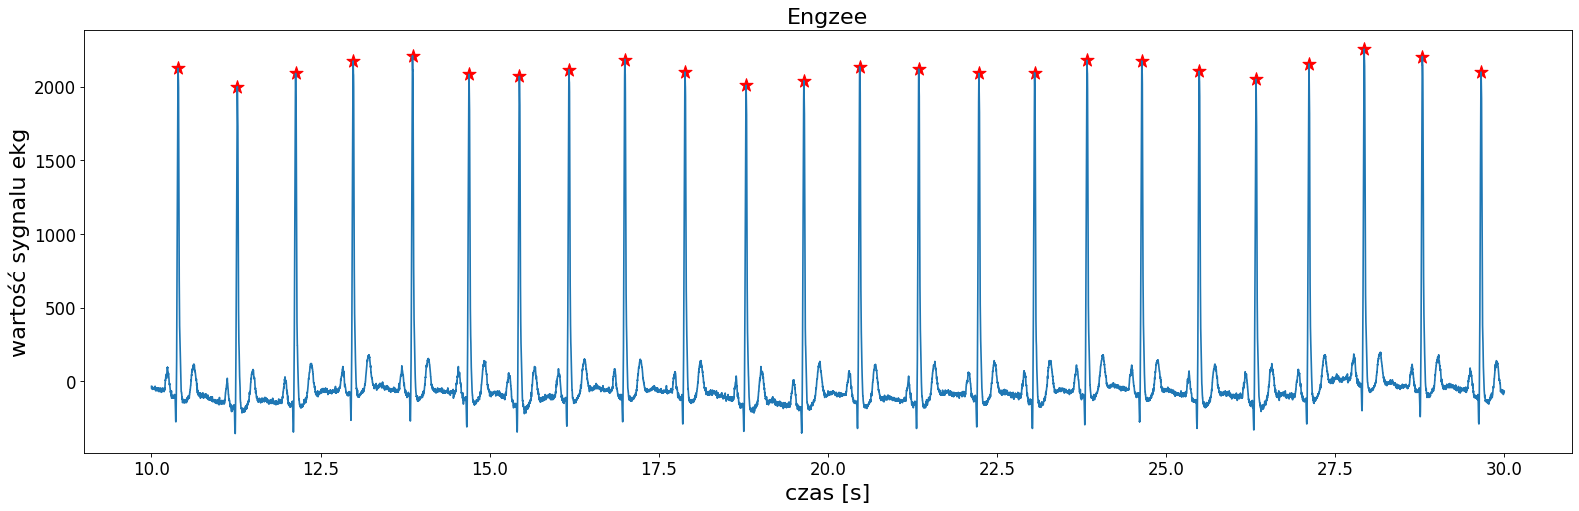

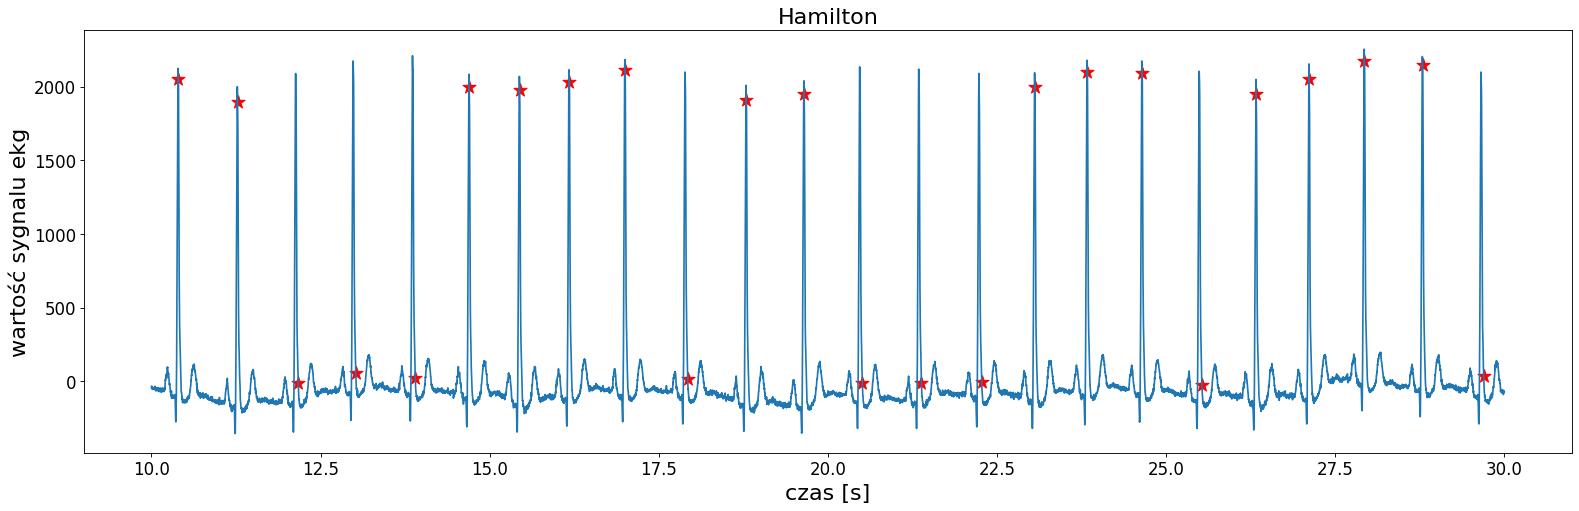

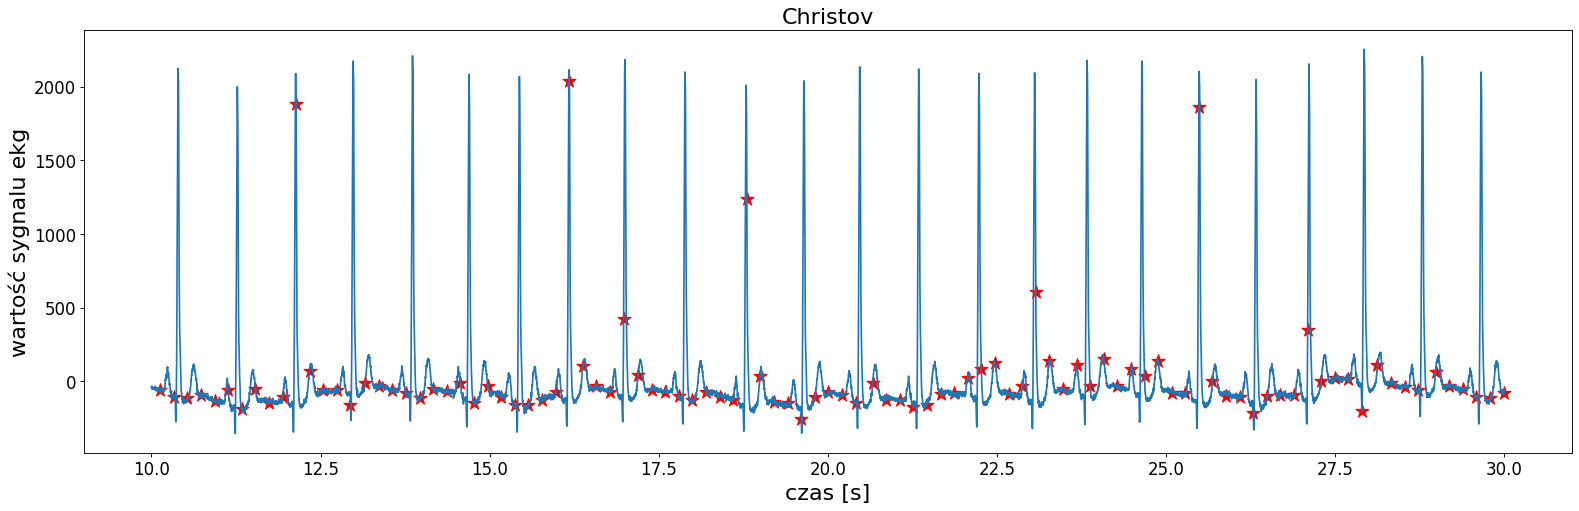

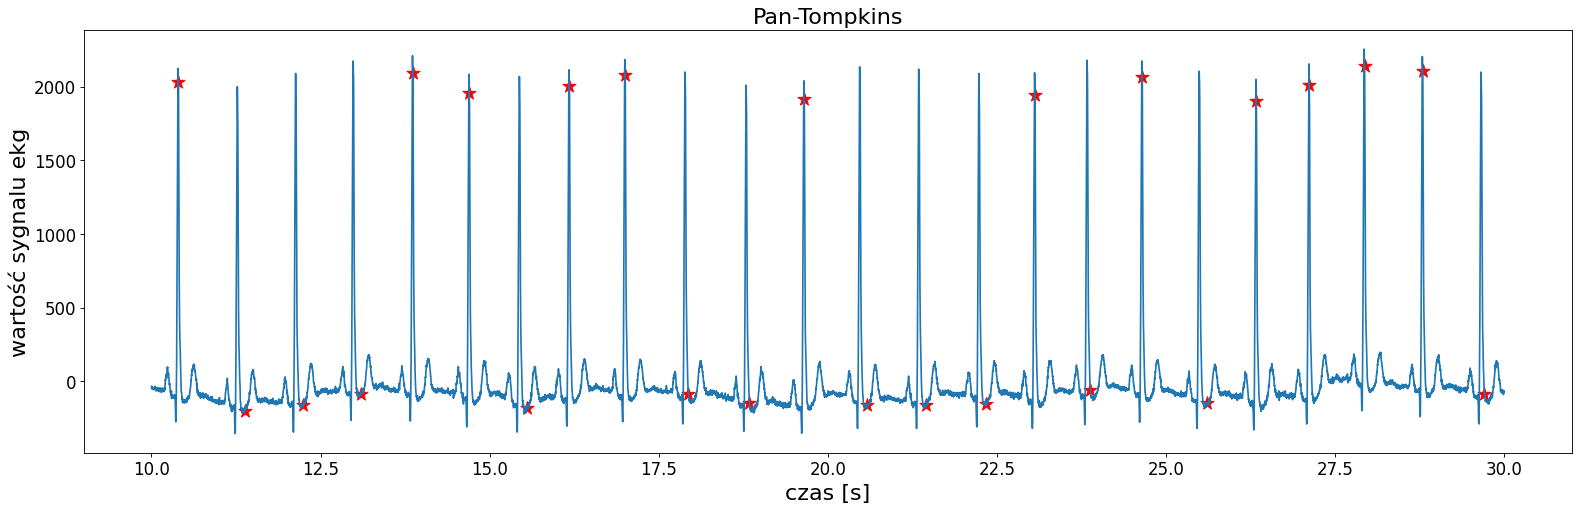

In [94]:
figure(figsize=(24, 7), dpi=80)
plt.plot(t[int(ten_secs[0]):int(thirty_secs[0])], 
         unfiltered_ecg[int(ten_secs[0]):int(thirty_secs[0])])
plt.scatter(t[[peaks for peaks in r_peaks_engzee if peaks > int(ten_secs[0]) and peaks < int(thirty_secs[0])]], 
unfiltered_ecg[[peaks for peaks in r_peaks_engzee if peaks > int(ten_secs[0]) and peaks < int(thirty_secs[0])]], 
                                            color = 'red', s = 150, marker= '*')
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15) 
plt.title("Engzee", fontsize=20)
plt.xlabel("czas [s]", fontsize=20)
plt.ylabel("wartość sygnalu ekg", fontsize=20)
plt.show() 

Ewaluacja działania detektorów - liczba wykrytych pików

Wyznaczenie R_peaks - różne filtry

Wyznaczenie czasu

Analiza statystyczna HRV

In [ ]:
#filtrowanie i wyznaczanie pików za pomocą find_peaks
from scipy.signal import firwin
def model(csvs : dict,person : str, ecg : str,height : list, distance : int) -> list: 
  unfiltered_ecg=csvs.get(person)
  unfiltered_ecg = unfiltered_ecg[ecg][unfiltered_ecg[ecg].notna()]
  band_pass=firwin(51,(5,15),pass_zero='bandpass',fs=1000)
  filtered_ecg=np.convolve(band_pass,unfiltered_ecg)
  peaks,heights = find_peaks(filtered_ecg,height=height,distance=distance)
  return peaks,filtered_ecg

In [ ]:
#rysowanie ekg z wykrytymi pikami
def rysuj(signal,r_peaks,start,stop):
  dt = 0.001 # sampling interval
  Fs = 1 / dt # sampling frequency
  t = np.arange(0, len(signal)/1000, dt)
  start = np.where(t == start)  
  stop = np.where(t == stop)
  figure(figsize=(20, 5), dpi=80)

  plt.plot(t[int(start[0]):int(stop[0])], 
          signal[int(start[0]):int(stop[0])])
  plt.scatter(t[[peaks for peaks in r_peaks if peaks > int(start[0]) and peaks < int(stop[0])]], 
  signal[[peaks for peaks in r_peaks if peaks > int(start[0]) and peaks < int(stop[0])]], 
                                              color = 'red', s = 50, marker= '*')
  plt.xticks(fontsize=15) 
  plt.yticks(fontsize=15)
  plt.xlabel("czas [s]", fontsize=20)
  plt.ylabel("wartość sygnalu ekg", fontsize=20)
  plt.grid(True)
  plt.show()

In [ ]:
#wyznaczanie tętna w czasie dla danego pomiaru
def tetno(csvs : dict,person : str,height : list, distance : list,draw : bool):
  ecg=['ekg0','ekg1','ekg2']
  data=csvs.get(person)
  tetno=[]
  for i in range (0,3):
    unfiltered_ecg = data[ecg[i]][data[ecg[i]].notna()]
    peaks,signal=model(csvs,person,ecg[i],height=height[i],distance=distance[i])
    if draw==True:
      rysuj(signal,peaks,1,int(len(signal)/1000)) 
    peak_distances = [peaks[i] - peaks[i-1] for i in range(1, len(peaks))]
    hr=60000/np.abs(peak_distances)
    tetno.append((hr,peaks))
  return tetno

In [ ]:
#ręcznie dobrane parametry dla każdego pliku, tak żeby poprawnie wykrywał piki (nie w 100%, ale pomyłki są wyłapywane później)
draw=False
MB=[tetno(csvs,'MBbez13.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'MBmat13.04.csv',[900,-4000,700],[250,250,250],draw),
    tetno(csvs,'MBch13.04.csv',[900,900,500],[250,250,250],draw),
    tetno(csvs,'MBff13.04.csv',[900,-2500,-1000],[300,250,300],draw)]

PG=[tetno(csvs,'PGbez13.04.csv',[900,500,900],[250,250,250],draw),
    tetno(csvs,'PGmat27.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'PGch13.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'PGff13.04.csv',[900,500,900],[250,250,250],draw)]

WK=[tetno(csvs,'WKbez27.04.csv',[900,800,700],[250,250,250],draw),
    tetno(csvs,'WKmat27.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'WKch27.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'WKff27.04.csv',[500,900,900],[250,250,250],draw)]
  
GP=[tetno(csvs,'GPbez27.04.csv',[750,500,400],[250,350,250],draw),
    tetno(csvs,'GPmat27.04.csv',[900,500,500],[250,250,250],draw),
    tetno(csvs,'WKch27.04.csv',[900,900,900],[250,250,250],draw),
    tetno(csvs,'GPff30.03.csv',[900,-500,550],[250,250,250],draw)]


NameError: ignored

In [ ]:
def smooth(signal,t,n):
  x=[]
  for i in range (0,n):
    x.append(1/n)
  smoothed=np.convolve(signal,x)[n:-n]
  if(n%2==0):
    n=int(n-(n-1)/2)
    t=t[n+1:-n]
  else:
    n=int(n-(n-1)/2)
    t=t[n:-n]
  return smoothed,t

In [ ]:
def detect_outliers(hr,time,threshold=10,n=3):
  outliers=[]
  for i in range(0,n):
    if np.abs(hr[i]-(np.sum(hr[0:i])+np.sum(hr[i+1:n]))/(n-1))>threshold:
        outliers.append(i)
  for i in range(len(hr)-n-1,len(hr)):
    if np.abs(hr[i]-(np.sum(hr[len(hr)-n-1:i])+np.sum(hr[i+1:len(hr)]))/(n-1))>threshold:
        outliers.append(i)
  for i in range(n,len(hr)-n-1):
    if np.abs(hr[i]-(np.sum(hr[len(hr)-n-1:i])+np.sum(hr[i+1:i+n])/(n-1)))>threshold:
        outliers.append(i)
  hr=np.delete(hr,outliers)
  time=np.delete(time,outliers)
  return hr,time

In [ ]:
def wykres_ekg(ekg,n_smooth=15,plot='plot',smoothing=True,del_outl=True):
  os=[GP,PG,MB,WK]
  fig = plt.figure(figsize=(12, 8))
  mean=np.zeros((4,4))
  for j in range(0,4):
    t=[]
    hr=[]
    for i in range (0,4):
      time=os[j][i][ekg][1][:-1]/1000
      signal=os[j][i][ekg][0]
      z1 = np.abs(stats.zscore(signal)) 
      outliers = np.where(z1 > 2) 
      for x in outliers: 
        signal = np.delete(signal, x)
        time = np.delete(time,x)
      if del_outl==True:
        signal,time=detect_outliers(signal,time)
      if smoothing==True:
        signal,time=smooth(signal,time,n_smooth)
      t.append(time)
      hr.append(signal)
    colors=['b','r','g','purple']
    labels=['bez maski','materiałowa','chirurgiczna','FFP2']
    if plot == 'plot':
      fig.add_subplot(2,2,j+1)
      for i in range(0,4):
        plt.plot(t[i],hr[i],colors[i],label=labels[i])
      plt.grid(True)
      plt.xlabel('Czas [s]')
      plt.ylabel('Tętno [bpm]')
      plt.legend(prop={'size': 6})
    if plot == 'boxplot':
      fig.add_subplot(2,2,j+1)
      for i in range(0,4):
        plt.boxplot(hr)
        mean[j][i]=np.mean(hr[i])
      plt.xticks([1,2,3,4],labels=labels)
      plt.ylabel('Tętno [bpm]')
    fig.show()
  print('Średnia każdego pomiaru: ',mean)
  print('Średnia każdej maseczki: ',np.mean(mean,axis=0))


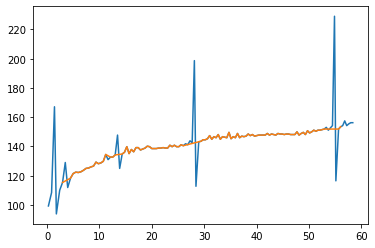

In [ ]:
time=PG[0][1][1][:-1]/1000
signal=PG[0][1][0]
plt.figure()
plt.plot(time,signal)
n_signal,n_time=detect_outliers(signal,time,5,n=5)
plt.plot(n_time,n_signal)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

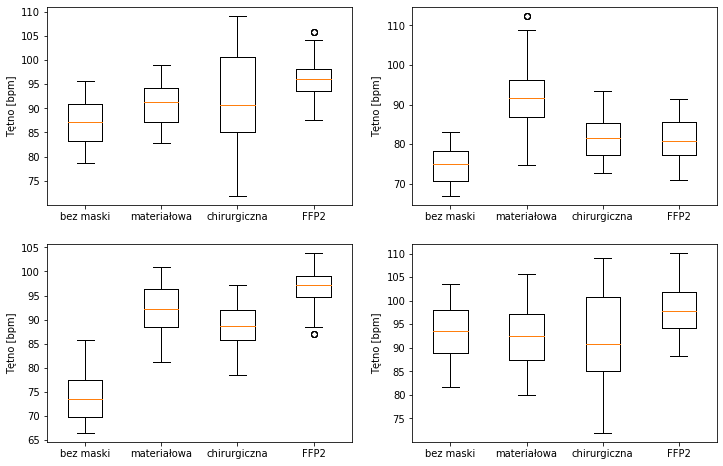

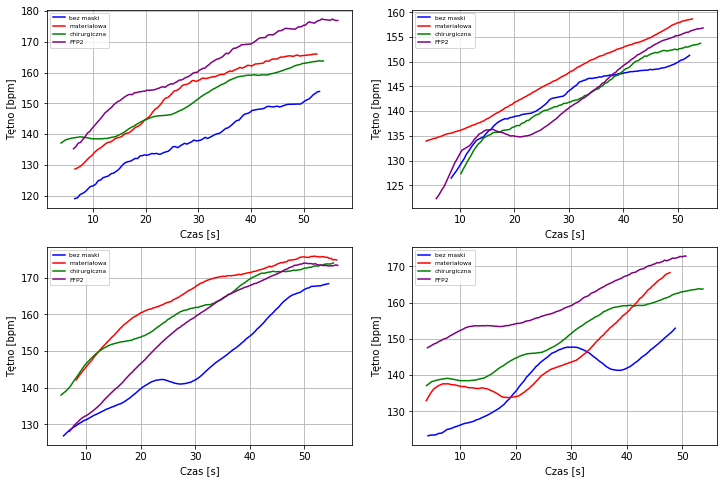

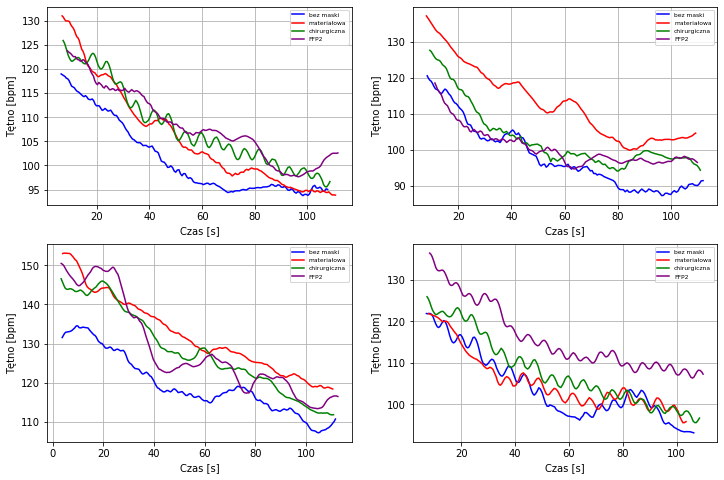

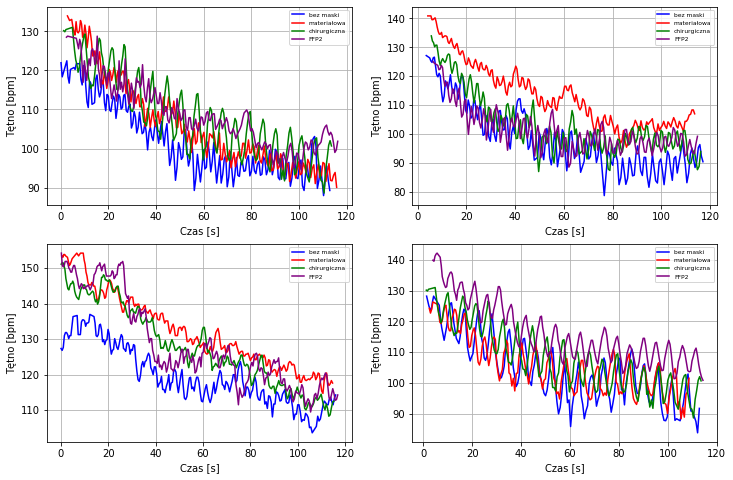

In [ ]:
#dla ekg0 pewnie lepsze boxploty, pozostaje jeszcze odrzucenie w kilku przypadkach wartości odstających (widocznych po wyłączeniu wygładzania)
wykres_ekg(0,15,plot='boxplot',smoothing=False) 
#wykres_ekg(1,smoothing=True,del_outl=False)
#wykres_ekg(1,smoothing=False,del_outl=False)
#wykres_ekg(1,smoothing=False,del_outl=True)
wykres_ekg(1,smoothing=True,del_outl=True)
wykres_ekg(2,smoothing=True)
wykres_ekg(2,smoothing=False)

In [ ]:
wykres_ekg(0,15,plot='boxplot',smoothing=False) 

NameError: ignored